<a href="https://colab.research.google.com/github/lipeng2021/-python1/blob/main/5_6AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from IPython import display
FILENAME =  '/home/lp'
import matplotlib.pyplot as plt
device = torch.device('cuda'if torch.cuda.is_available()else 'cpu')
import time

In [10]:
class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=96,kernel_size=11,stride=4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2),#(1)
        nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5,stride=1,padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2),#(2)
        nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),#(3)
        nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),#(4)
        nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2)#(5)
    )
    self.fc = nn.Sequential(
        nn.Linear(256*5*5,4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096,10),
    )
  def forward(self,image):
    feature = self.conv(image)
    output = self.fc(feature.view(image.shape[0],-1))
    return output

In [11]:
net = AlexNet()
print(net)

AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

In [12]:
def load_data_fashion_mnist(batch_size,resize=None,root='/home/lp'):
  trans = []
  if resize:
    trans.append(torchvision.transforms.Resize(size=resize))
  trans.append(torchvision.transforms.ToTensor())
  transform = torchvision.transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(root=root,train=True,transform=transform,download=True)
  mnist_test = torchvision.datasets.FashionMNIST(root=root,train=False,transform=transform,download=True)
  train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)
  test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=True,num_workers=4)
  return train_iter,test_iter

batch_size = 128
train_iter,test_iter = load_data_fashion_mnist(batch_size,resize=224)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
def evalucate_accuracy(data_iter,net,device):
  acc_sum=0.0
  n=0
  with torch.no_grad():
    for X,y in data_iter:
     if isinstance(net,nn.Module):
        net.eval()
        acc_sum += (net(X.to(device)).argmax(dim=1)==y.to(device)).float().sum().cpu().item()
        net.train()
     else:
      if ('is_training'in net.__code__.co_varnames):
        acc_sum +=(net(X,is_training=False).argmax(dim=1)==y).float().sum().item()
      else:
        acc_sum +=(net(X).argmax(dim=1)==y).float().sum().item()
     n +=y.shape[0]
    return acc_sum/n

In [16]:
def train_ch5(net,train_iter,test_iter,batch_size,device,optimizer,num_epochs):
  loss = torch.nn.CrossEntropyLoss()
  net.to(device)
  print('train on',device)
  batch_cout = 0 
  for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc_sum = 0.0
    n = 0
    start = time.time()
    for X,y in train_iter:
      X=X.to(device)
      y=y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_loss += l.cpu().item()
      train_acc_sum += (net(X).argmax(dim=1)==y).float().sum().cpu().item()
      n += y.shape[0]
      batch_cout +=1
    test_acc_sum = evalucate_accuracy(test_iter,net,device)
    print('epoch:%d,loss:%.4f,train_acc:%.3f,test_acc:%.3f,time:%.1f'%(epoch+1,train_loss/batch_cout,train_acc_sum/n,test_acc_sum,time.time()-start))

In [17]:
lr = 0.001
num_epochs=5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net,train_iter,test_iter,batch_size,device,optimizer,num_epochs)

train on cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch:1,loss:0.2307,train_acc:0.926,test_acc:0.904,time:191.3
epoch:2,loss:0.1072,train_acc:0.931,test_acc:0.909,time:191.1
epoch:3,loss:0.0662,train_acc:0.936,test_acc:0.912,time:184.2
epoch:4,loss:0.0472,train_acc:0.940,test_acc:0.917,time:184.5
epoch:5,loss:0.0366,train_acc:0.943,test_acc:0.916,time:191.5


In [18]:
!nvidia-smi

Thu Apr 21 08:59:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    59W / 149W |   3658MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


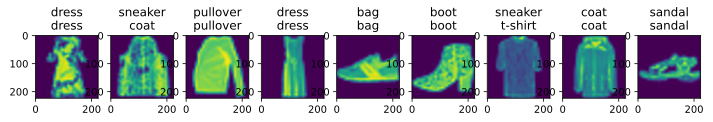

In [22]:
def get_fashion_mnist_labels(labels):
  text_labels = ['t-shirt','trouser','pullover','dress','coat','sandal','sneaker','bag','ankle','boot']
  return [text_labels[int(i)] for i in labels]
def show_fashion_mnist(images,labels):
  display.set_matplotlib_formats('svg')
  _,imgs = plt.subplots(1,len(images),figsize=(12,12))
  for img,figture,lbl in zip(imgs,images,labels):
    img.imshow(figture.view((224,224)).numpy())
    img.set_title(lbl)
    img.axes.get_xaxis().set_visible(True)
    img.axes.get_yaxis().set_visible(True)
  plt.show()
x,y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(x.to(device)).argmax(dim=1).cpu().numpy())
title = [true+'\n'+pred for true,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(x[0:9],title[0:9])